# Seasonal forecast management

This notebook is based on the [companion](https://github.com/SantanderMetGroup/notebooks/blob/master/2018_ECOMS-UDG_ClimateServices.pdf) to the paper: 

> Cofiño, A.S., J. Bedia, M. Iturbide, M. Vega, S. Herrera, J. Fernández, M.D. Frías, R. Manzanas, J.M. Gutiérrez (2017)
_The ECOMS User Data Gateway: Towards seasonal forecast data provision and research reproducibility in the era of Climate Services._
Climate Services 9:33-43. DOI: [https://doi.org/10.1016/j.cliser.2017.07.001](https://doi.org/10.1016/j.cliser.2017.07.001)




## R PACKAGE REQUIREMENTS 

The following R packages are required to follow the examples. Note the last **Session Information Section** of this tutorial, where the specific package versions used to build these examples are indicated.

### R packages for data loading

The R package `loadeR.ECOMS` will perform the data loading task, including authentication against the UDG server. In addition, a quick overview of all datasets and variables available in the ECOMS-UDG is available in [this table](http://meteo.unican.es/ecoms-udg/dataserver/catalog)

The `loadeR.ECOMS` package extends the capabilities of the `loadeR` package for data access, and enables access to any remote dataset via OPeNDAP (more details in the [loadeR's wiki page](https://github.com/SantanderMetGroup/loadeR/wiki)), as well as creating and accesing datasets locally. An example of remote access to a public dataset outside the ECOMS-UDG is provided in Section 4. 

In [1]:
library(loadeR.ECOMS)
library(transformeR)
library(visualizeR)

Loading required package: loadeR

Loading required package: rJava

Loading required package: loadeR.java

Java version 11x amd64 by Oracle Corporation detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.4 (2022-06-15) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.7.1 (2021-07-05) is loaded

Please use 'citation("loadeR")' to cite this package.

loadeR.ECOMS version 1.4.6 (2018-10-20) is loaded

Please use 'citation("loadeR.ECOMS")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.0 (2021-03-17) is loaded


Get the latest stable version (2.1.4) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.0 (2020-05-23) is loaded


Get the latest stable version (1.6.1) using <devtools::install_github('SantanderMetGroup/visualizeR')>

Please see 'citation("visualizeR")' to cite this package.



### R packages for verification 

Two packages for verification have been developed in the frame of ECOMS: `SpecsVerification` (Siegert 2017), in SPECS, and `easyVerification` (MeteoSwiss 2017), in EUPORIAS. Both packages are available on CRAN. The former is a dependency of the latter, so installing `easyVerification` will also install `SpecsVerification` if not already present:

In [2]:
library(easyVerification)

Loading required package: SpecsVerification


Attaching package: ‘easyVerification’


The following object is masked from ‘package:SpecsVerification’:

    EnsCorr




### Additional packages

The package `RColorBrewer` is used to replicate the spectral color palette used in the paper in the correlation maps. Next, the palette `veri.colors` is defined, that will be used in the verification maps:

In [3]:
library(RColorBrewer)
cols <- brewer.pal(n = 11, name = "Spectral")
veri.colors <- colorRampPalette(rev(cols))

## ANALYSIS OF THE WINTER NAO INDEX 

### Data Loading 

NOTE: the datasets used in this section already post-processed are available for direct download

In [4]:
# NCEP reanalysis SLP
url <- "http://meteo.unican.es/work/UDG/NCEP_psl_DJF_annual_1949_2010_LD.Rdata"
data.file <- basename(url)
if (! file.exists(data.file))
  download.file(url, destfile = data.file)
load(data.file, .GlobalEnv, verbose = TRUE)

Loading objects:
  ncep.psl


In [5]:
# CFSv2 SLP
url <- "http://meteo.unican.es/work/UDG/CFS_24_lm1_psl_DJF_annual_1983_2010_LD.Rdata"
data.file <- basename(url)
if (! file.exists(data.file))
  download.file(url, destfile = data.file)
load(data.file, .GlobalEnv, verbose = TRUE)

Loading objects:
  cfs.psl


Prior to data access, authentication is required to access the UDG. The authentication is performed in one step:

```R
loginUDG(username = "****", password = "*****")
```

You can also read the credentials from a plain text file with two lines (the user and password), so you don't need to expose them in your notebooks:

In [6]:
do.call(loginUDG, as.list(readLines("udg_login.txt")))

[2022-08-26 13:00:56] Setting credentials...

[2022-08-26 13:00:56] Success!
Go to <https://data.meteo.unican.es/udg-tap/home> for details on your authorized groups and datasets



#### NCEP Reanalysis1 data

The spatial domain to compute the PC-based NAO index is indicated in [NCAR's Climate Data Guide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based)

In [7]:
lonLim = c(-90,40)
latLim = c(20,80)
var = "psl"

Note that `"psl"` is the standard name defined in the UDG vocabulary for sea-level pressure. The UDG vocabulary can be inspected by typing `UDG.vocabulary()`. The sea-level pressure data from the NCEP reanalysis (`dataset = "NCEP_reanalysis1"`) is loaded in order to reconstruct the observed winter NAO index (`season = c(12,1,2)`) for the entire reanalysis period (1950-2010) (`years = NULL`, the default, which retrieves all available years. This is equivalent to `years = 1950:2010` in this case). As the original data are 6-hourly, data are aggregated on-the-fly by `loadeR.ECOMS` by introducing the arguments `time = "DD"` (to conver the data from 6-h to daily), `aggr.d = "mean"` (to indicate the aggregation function) and `aggr.m = "mean"` (which indicates that daily data will be monthly averaged).

In [8]:
# test (renamed function?)
UDG.vocabulary()

ERROR: Error in UDG.vocabulary(): could not find function "UDG.vocabulary"


In [12]:
ncep.psl <- loadECOMS(dataset = "NCEP_reanalysis1",
                      var = var,
                      lonLim = lonLim,
                      latLim = latLim,
                      season = c(12,1,2),
                      years = NULL,
                      time = "DD",
                      aggr.d = "mean",
                      aggr.m = "mean")

ERROR: Error in var == "tp": comparison (1) is possible only for atomic and list types


Next we represent the mean sea-level pressure winter climatology:

In [9]:
plotClimatology(climatology(ncep.psl),
                backdrop.theme = "coastline",
                main = "NCEP mean DJF SLP (1950-2010)")

ERROR: Error in plotClimatology(climatology(ncep.psl), backdrop.theme = "coastline", : could not find function "plotClimatology"


#### CFSv2 seasonal hindcast data

The corresponding hindcast is loaded in a similar way, but taking into account that in this case, it is necessary to specify two additional parameters to unequivocally define the query: the members (for instance, the first 24 members: `members = 1:24`) and the initialization time (e.g., 1-month ahead predictions: `leadMonth = 1`). Here, we illustrate this step using the data from the CFSv2 hindcast (`dataset = "CFSv2_seasonal"`). Note that the only difference between this example call to `loadECOMS` and a request for the other two hindcasts compared in the paper, would lie just in the dataset argument: `dataset = "Glosea5_seasonal_24"` for the UKMO Glosea5 hindcast of 24 members, or `dataset = "System4_seasonal_51"` for the ECMWF System4 seasonal hindcast of 51 members. Thanks to the [data harmonization](http://meteo.unican.es/ecoms-udg/RPackage/homogeneization) performed by `loadeR.ECOMS`, the rest of parameters (variable naming...) remain exactly the same. Member selection is also transparent to users, who don't need to worry about the different member configurations. As an example, see the CFSv2 [lagged runtime member configuration](http://meteo.unican.es/ecoms-udg/dataserver/datasets/CFSv2) and the definition of members undertaken via `loadECOMS`.

cfs.psl <- loadECOMS(dataset = "CFSv2_seasonal",
                     var = var,
                     lonLim = lonLim,
                     latLim = latLim,
                     season = c(12,1,2),
                     years = NULL,
                     time = "DD",
                     aggr.d = "mean",
                     aggr.m = "mean",
                     members = 1:24,
                     leadMonth = 1)
```
```{r,fig.align='center',fig.width=10,fig.height=9,message=FALSE}
plotClimatology(climatology(cfs.psl),
                backdrop.theme = "coastline",
                main = "Mean DJF SLP (1983-2010)")
```

### Temporal aggregation

Monthly data are annually aggregated next:

In [10]:
ncep.psl <- aggregateGrid(grid = ncep.psl, aggr.y = list(FUN = "mean"))
cfs.psl <- aggregateGrid(grid = cfs.psl, aggr.y = list(FUN = "mean"))

Data is already annual: 'aggr.y' option was ignored.

Data is already annual: 'aggr.y' option was ignored.



### NAO INDEX 

The PC-based NAO index is defined as the leading EOF of the sea-level pressure anomalies. The methodological details and reference time-series are presented in the [NCAR's Climate Data Guide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based). 

#### Observed NAO Index

After data loading, the NAO-Index can be calculated in two simple steps using the transformation tools available in `transformeR`:

  1. The anomalies are computed using `rescaleGrid` with its default arguments:

In [11]:
psl.anom <- localScaling(grid = ncep.psl)

Warning message:
“'localScaling' is deprecated and will be removed from transformeR in future releases.
Use 'scaleGrid' instead.”
[2022-08-26 20:57:34] - Scaling ...

[2022-08-26 20:57:34] - Done



  2. The EOFs (in this case only the first one) are computed using the `prinComp` function, and then plotted with `plotEOF`:

NOTE: Variable subsetting was ignored: Input grid is not a multigrid object

[2022-08-26 21:05:20] Performing PC analysis on 1 variable ...

[2022-08-26 21:05:20] Done.

Warning message:
“plotEOF is Deprecated. Please consider using transformeR::EOF2clim in combination with visualizeR::spatialPlot”


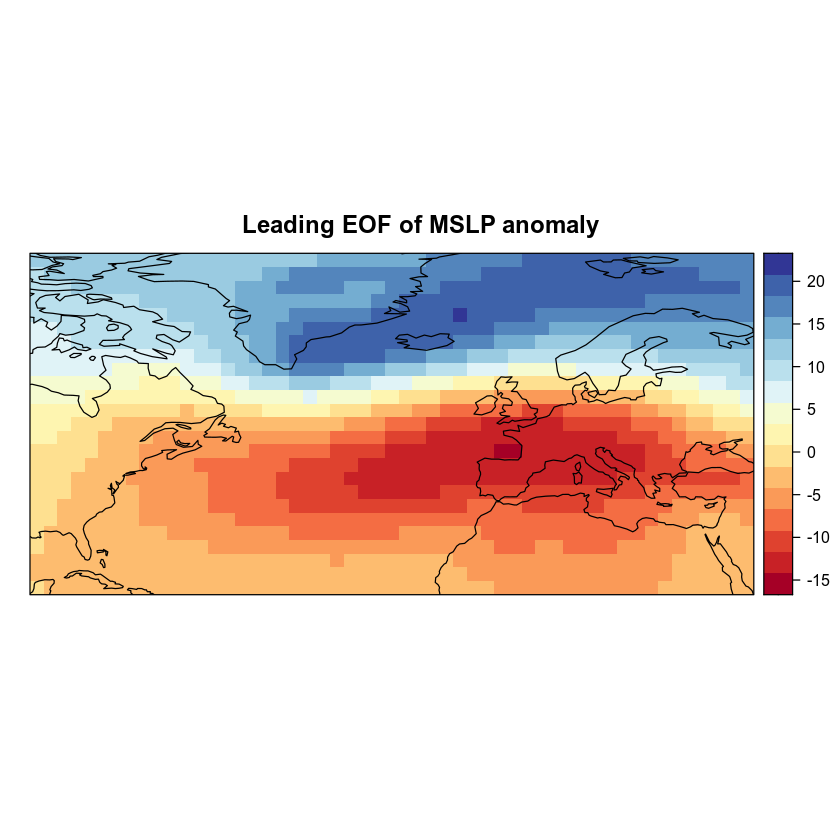

In [13]:
pca1 <- prinComp(psl.anom, n.eofs = 1)
plotEOF(pca1, var = "psl", n.eofs = 1, backdrop.theme = "coastline",
        main = "Leading EOF of MSLP anomaly")

The next lines of code extract the leading PC as a time-series grid, and plots it as a NAO-index time series (see [this link](https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/nao_pc_djf_2.gif?itok=rVOww1Wi) for a visual comparison with Hurrel's PC-based NAO-Index).

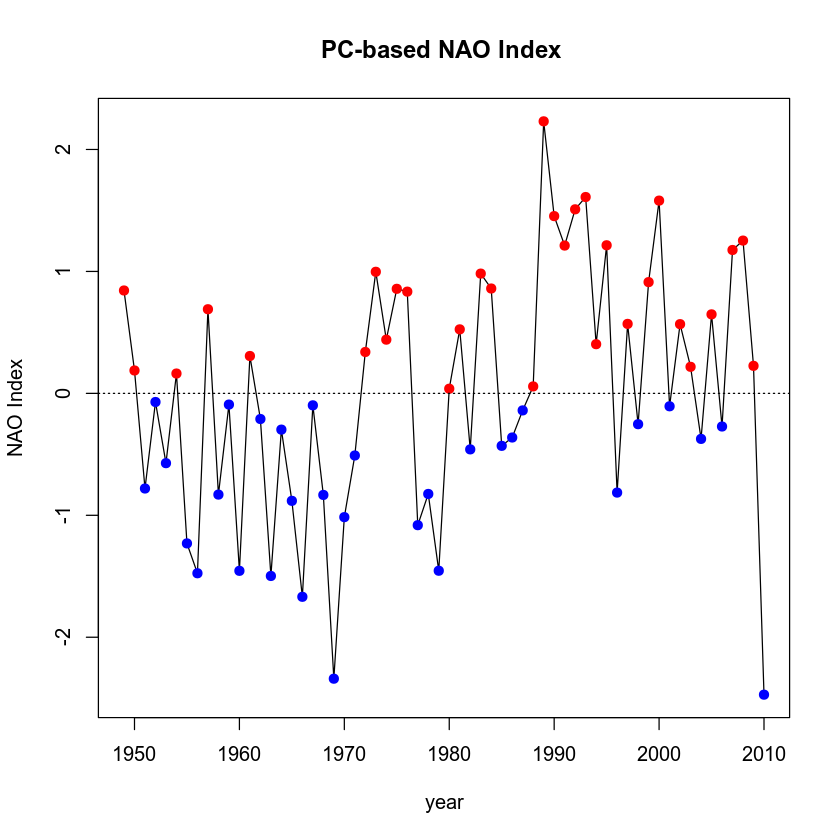

In [14]:
nao <- PC2grid(pca1, scale = TRUE, opp = TRUE)
nao.index.ncep <- nao[["Data"]][1,,1,1]
years <- getYearsAsINDEX(ncep.psl)
plot(years, nao.index.ncep, ty = 'l', ylab = "NAO Index", xlab = "year")
pos <- which(nao.index.ncep > 0) ## Index of positive NAO years
neg <- setdiff(1:length(nao.index.ncep), pos) ## Index of negative NAO years
points(years[pos], nao.index.ncep[pos], pch = 19, col = "red")
points(years[neg], nao.index.ncep[neg], pch = 19, col = "blue")
abline(h = 0, lty = 3)
title(main = "PC-based NAO Index ")

#### Hindcast NAO Index

First, the CFSv2 data are interpolated from the original model grid to the NCEP grid:

In [15]:
psl.cfs.interp <- interpGrid(grid = cfs.psl, new.coordinates = getGrid(ncep.psl))

[2022-08-26 21:13:21] Calculating nearest neighbors...

[2022-08-26 21:13:21] Performing nearest interpolation... may take a while

[2022-08-26 21:13:21] Interpolating member 1 out of 24

[2022-08-26 21:13:21] Interpolating member 2 out of 24

[2022-08-26 21:13:21] Interpolating member 3 out of 24

[2022-08-26 21:13:21] Interpolating member 4 out of 24

[2022-08-26 21:13:21] Interpolating member 5 out of 24

[2022-08-26 21:13:21] Interpolating member 6 out of 24

[2022-08-26 21:13:21] Interpolating member 7 out of 24

[2022-08-26 21:13:21] Interpolating member 8 out of 24

[2022-08-26 21:13:21] Interpolating member 9 out of 24

[2022-08-26 21:13:21] Interpolating member 10 out of 24

[2022-08-26 21:13:21] Interpolating member 11 out of 24

[2022-08-26 21:13:21] Interpolating member 12 out of 24

[2022-08-26 21:13:21] Interpolating member 13 out of 24

[2022-08-26 21:13:21] Interpolating member 14 out of 24

[2022-08-26 21:13:21] Interpolating member 15 out of 24

[2022-08-26 21:13:21] 

Next, the same steps as in the previous section are followed:

  1. Anomaly calculation 

In [16]:
psl.cfs.anom <- localScaling(psl.cfs.interp)

Warning message:
“'localScaling' is deprecated and will be removed from transformeR in future releases.
Use 'scaleGrid' instead.”
[2022-08-26 21:14:20] - Scaling ...

[2022-08-26 21:14:21] - Done



  2. PC calculation. In this case, the PCs are obtained using the NCEP EOF previously calculated, using the function `grid2PCs` as follows:

In [17]:
cfs.pc.list <- grid2PCs(pca1, grid = psl.cfs.anom)

The output is a list with the first PC for each of the 24 members. It is then converted into a `matrix` (members in columns, years in rows), which is also scaled to get the final NAO-Index:

In [18]:
nao.index.cfs <- sapply(cfs.pc.list, function(x) scale(x)*-1)

NULL

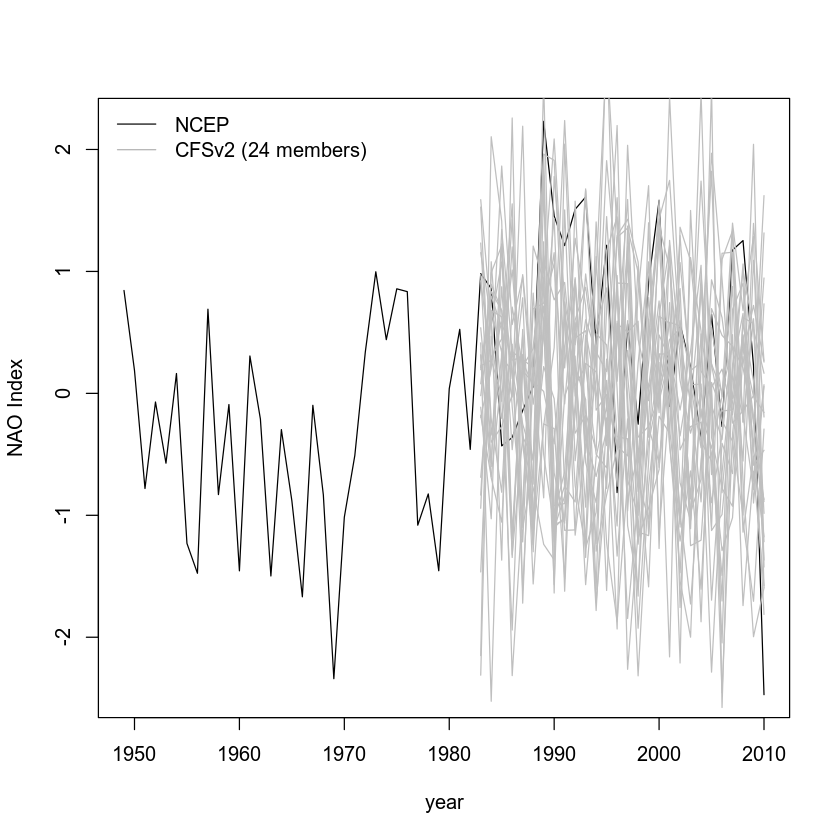

In [19]:
plot(years, nao.index.ncep, ty = 'l', ylab = "NAO Index", xlab = "year")
years.hind <- getYearsAsINDEX(cfs.psl)
apply(nao.index.cfs, MARGIN = 2, FUN = function(x) lines(years.hind, x, col = "grey75"))
legend("topleft", c("NCEP","CFSv2 (24 members)"), lty = 1, col = c(1, "grey70"), bty = "n")

### Correlation analysis

For simplicity, only the NCEP years overlapping the hindcast time period (1983-2010) are retained:

In [20]:
ref <- intersect(years, years.hind)
nao.index.ncep <- nao.index.ncep[years %in% ref]

Next, the correlation between the ensemble mean and NCEP is calculated:

In [21]:
cor(rowMeans(nao.index.cfs), nao.index.ncep)

[1] 0.4186522

The next lines of code, plot the observed Winter NAO Index against the hindcast predictions. Both the ensemble mean (orange line) and the individual members (red dots) are displayed: 

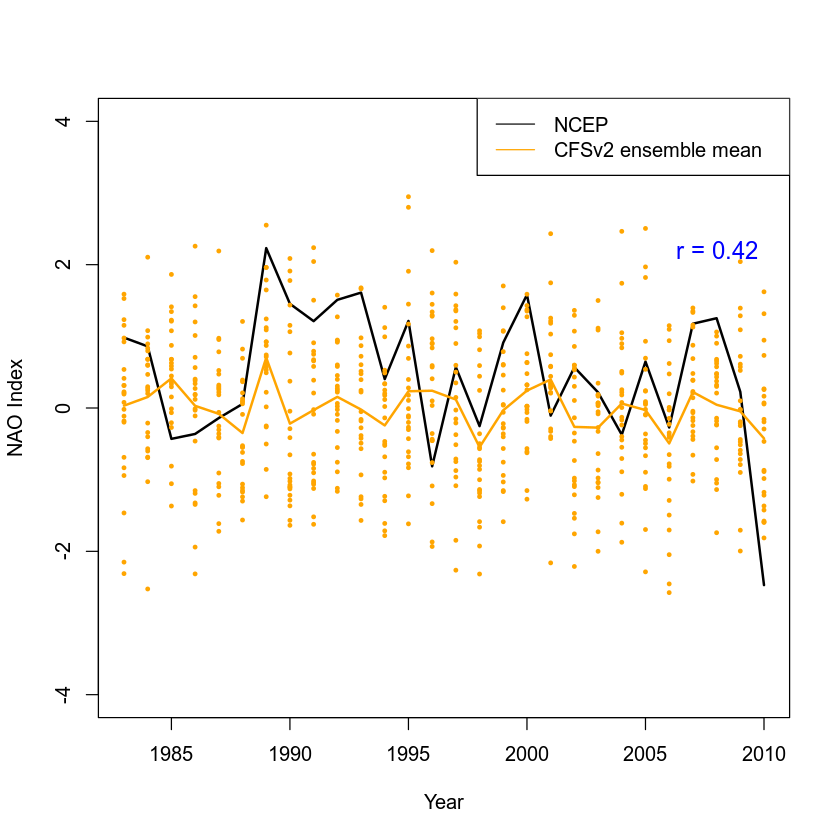

In [22]:
plot(ref, nao.index.ncep, ty = 'l', ylab = "NAO Index", xlab = "Year", ylim = c(-4,4), lwd = 2)
lines(ref, rowMeans(nao.index.cfs), col = "orange", lwd = 2)
legend("topright", c("NCEP","CFSv2 ensemble mean"), lty = 1, col = c(1,"orange"))
for (i in 1:length(ref)) {
    points(rep(ref[i], ncol(nao.index.cfs)), nao.index.cfs[i,], cex = .4, pch = 19, col = "orange")
}
text(2008, 2.2, cex = 1.2, col = "blue", bty = "n", paste("r =", round(cor(rowMeans(nao.index.cfs), nao.index.ncep), 2)))

### Bootstrap analysis

For convenience, we next create a matrix (`nao.mat`) containing the NCEP NAO-Index in its first column, and the 24 NAO-Index members from CFSv2 in the remaining columns.

In [23]:
nao.mat <- cbind(nao.index.ncep, nao.index.cfs)

The _ad-hoc_ function `boot.corr` is envisaged to perform the bootstrapping either on members, on years or on both variables simultaneously, as indicated by the argument `what`:

In [24]:
boot.corr <- function(df, R = 1000, what = c("members", "years")) {
    df <- df[complete.cases(df), ]
    what <- match.arg(what, c("members", "years"), several.ok = TRUE)
    mem <- 1:ncol(df)
    yrs <- 1:nrow(df)
    out <- rep(NA, R)
    iter <- 1
    ind.col <- 1:length(mem)
    ind.row <- 1:length(yrs)
    while (iter <= R) {
        if ("members" %in% what) ind.col <- sample(mem, size = length(mem), replace = TRUE)
        if ("years" %in% what) ind.row <- sample(yrs, size = length(yrs), replace = TRUE)
        out[iter] <- cor(rowMeans(df[ind.row,ind.col]), df[ind.row,1])
        iter <- iter + 1 
    }
    return(out)
}

The boostrapped correlations are next computed, and the results summarized in a boxplot, similar to Fig. 4 in the paper:

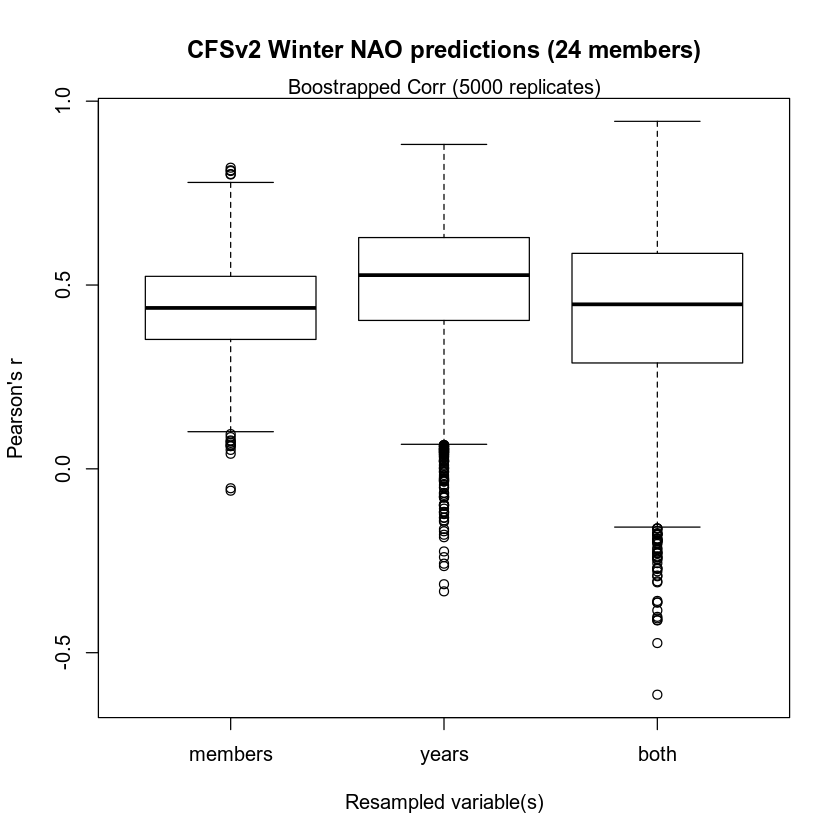

In [25]:
R = 5000 # Number of replicates
what.list <- list("members", "years", c("members","years"))
res <- vapply(1:length(what.list), FUN.VALUE = numeric(R), FUN = function(x) {
    boot.corr(nao.mat, R, what = what.list[[x]])
})
boxplot(res, names = c("members", "years", "both"), ylab = "Pearson's r", xlab = "Resampled variable(s)")
title("CFSv2 Winter NAO predictions (24 members)")
mtext(paste0("Boostrapped Corr (", R, " replicates)"))

## VERIFICATION OF MEAN WINTER TEMPERATURE FORECASTS IN THE NORTH-ATLANTIC DOMAIN 

**NOTE: the datasets used in this section already post-processed  are available for direct download (skip this section and jump to Section 3.2 if loaded through the next lines of code)**

In [26]:
# NCEP tas
url <- "http://meteo.unican.es/work/UDG/NCEP_tas_DJF_annual_1983_2010_LD.Rdata"
data.file <- basename(url)
if (! file.exists(data.file))
  download.file(url, destfile = data.file)
load(data.file, .GlobalEnv, verbose = TRUE)

# CFSv2 tas
url <- "http://meteo.unican.es/work/UDG/CFS_24_lm1_tas_DJF_annual_1983_2010_LD.Rdata"
data.file <- basename(url)
if (! file.exists(data.file))
  download.file(url, destfile = data.file)
load(data.file, .GlobalEnv, verbose = TRUE)

Loading objects:
  tas.ncep
Loading objects:
  tas.cfs


The geographical window used for the NAO Index calculation is defined: 

In [27]:
lonLim = c(-90,40)
latLim = c(20,80)

### Data loading 

#### NCEP reanalysis

In [29]:
tas.ncep <- loadECOMS(dataset = "NCEP_reanalysis1",
                      var = "tas",
                      lonLim = lonLim,
                      latLim = latLim,
                      season = c(12,1,2),
                      years = NULL,
                      time = "DD",
                      aggr.d = "mean",
                      aggr.m = "mean")

[2022-08-26 21:26:55] Defining harmonization parameters for variable "tas"

[2022-08-26 21:26:55] Opening dataset...



ERROR: Error: UNAUTHORIZED to open the requested dataset.
Check your login details and authorized datasets.


Next we represent the mean temperature winter climatology:

In [30]:
plotClimatology(climatology(tas.ncep), backdrop.theme = "coastline", main = "NCEP DJF Mean Temperature (1983-2010)")

ERROR: Error in plotClimatology(climatology(tas.ncep), backdrop.theme = "coastline", : could not find function "plotClimatology"


#### CFSv2 seasonal hindcast

Next, the CFSv2 temperature hindcast predictions are loaded. Note that the arguments passed to `loadECOMS` are the same as in the previous call, but changing the value of `var` to `tas`, which is the harmonized name for near-surface air temperature:

In [ ]:
tas.cfs <- loadECOMS(dataset = "CFSv2_seasonal",
                     var = "tas",
                     lonLim = lonLim,
                     latLim = latLim,
                     season = c(12,1,2),
                     years = NULL,
                     time = "DD",
                     aggr.d = "mean",
                     aggr.m = "mean",
                     members = 1:24,
                     leadMonth = 1)

### Temporal aggregation and interpolation

Monthly data are annually aggregated:

In [31]:
tas.ncep <- aggregateGrid(grid = tas.ncep, aggr.y = list(FUN = "mean"))
tas.cfs <- aggregateGrid(grid = tas.cfs, aggr.y = list(FUN = "mean"))

Data is already annual: 'aggr.y' option was ignored.

Data is already annual: 'aggr.y' option was ignored.



Furthermore, the CFSv2 data are interpolated to match the NCEP reanalysis grid:

In [32]:
tas.cfs <- interpGrid(tas.cfs, new.coordinates = getGrid(tas.ncep), method = "bilinear")

Warning message in interpGrid(tas.cfs, new.coordinates = getGrid(tas.ncep), method = "bilinear"):
“The new latitudes are outside the data extent”
[2022-08-26 21:32:00] Performing bilinear interpolation... may take a while

[2022-08-26 21:32:00] Interpolating member 1 out of 24

[2022-08-26 21:32:00] Interpolating member 2 out of 24

[2022-08-26 21:32:01] Interpolating member 3 out of 24

[2022-08-26 21:32:01] Interpolating member 4 out of 24

[2022-08-26 21:32:01] Interpolating member 5 out of 24

[2022-08-26 21:32:01] Interpolating member 6 out of 24

[2022-08-26 21:32:02] Interpolating member 7 out of 24

[2022-08-26 21:32:02] Interpolating member 8 out of 24

[2022-08-26 21:32:02] Interpolating member 9 out of 24

[2022-08-26 21:32:02] Interpolating member 10 out of 24

[2022-08-26 21:32:02] Interpolating member 11 out of 24

[2022-08-26 21:32:03] Interpolating member 12 out of 24

[2022-08-26 21:32:03] Interpolating member 13 out of 24

[2022-08-26 21:32:03] Interpolating member 14

The resulting hindcast data are next plotted:

In [33]:
plotClimatology(climatology(tas.cfs), backdrop.theme = "coastline", main = "Mean DJF Temperature (1983-2010)")

ERROR: Error in plotClimatology(climatology(tas.cfs), backdrop.theme = "coastline", : could not find function "plotClimatology"


### Correlation analysis

In [37]:
obs <- tas.ncep[["Data"]]
fcst <- tas.cfs[["Data"]]
cor <- veriApply(verifun = "EnsCorr", fcst = fcst, obs = obs, ensdim = 1, tdim = 2)

The object `corr` contains the correlation coefficients for each grid point. The bridging function `easyVeri2grid` from package `transformeR` performs the transformation from the raw verification matrices produced by `easyVerification` to the grid structure with all the required metadata for data collocation and representation handled by the `climate4R` bundle packages (including `transformeR`):

In [38]:
cor.grid <- easyVeri2grid(easyVeri.mat = cor, obs.grid = tas.ncep, verifun = "EnsCorr")

It is now straightforward the representation of the correlation map, that is treated as a climatology (i.e., the time dimension is a singleton). Additional arguments are needed in order to mimic the spectral color palette used in the paper (previously defined in Sec. 1.4). Extremely flexible plotting options are available, since `plotClimatology` is a wrapper for the powerful `spplot` method for spatial representation of geospatial `sp` objects in R, thus accepting all its arguments.

In [36]:
plotClimatology(climatology(cor.grid),
                backdrop.theme = "countries",
                col.regions = veri.colors(51), ## Define color palette
                at = seq(-1,1,.05), ## Set range of values
                colorkey = list(space = "bottom"), ## Place legend at bottom
                main = "Ensemble correlation",
                sub = "CFSv2 24 member - DJF Mean Temperature (1983-2010)")

ERROR: Error in plotClimatology(climatology(cor.grid), backdrop.theme = "countries", : could not find function "plotClimatology"


## VERIFICATION OF MEAN WINTER TEMPERATURE OVER WESTERN EUROPE 

**NOTE: the datasets used in this section are available already post-processed for direct download (skip this section and jump to next section if loaded this way):**

In [39]:
# EOBS mean temperature
url <- "http://meteo.unican.es/work/UDG/EOBS_tas_DJF_annual_1983_2010.Rdata"
data.file <- basename(url)
if (! file.exists(data.file))
  download.file(url, destfile = data.file)
load(data.file, .GlobalEnv, verbose = TRUE)
# CFSv2 
url <- "http://meteo.unican.es/work/UDG/CFS_24_tas_DJF_annual_1983_2010.Rdata"
data.file <- basename(url)
if (! file.exists(data.file))
  download.file(url, destfile = data.file)
load(data.file, .GlobalEnv, verbose = TRUE)

Loading objects:
  eobs.tas
Loading objects:
  tas.cfs


### Data loading 

#### CFSv2 temperature

A spatial window centered in western Europe is next defined. The harmonized name for near-surface temperature is `"tas"`, being its units degrees Celsius (see `UDG.vocabulary()`):

In [40]:
lonLim = c(-10,30)
latLim = c(35,70)

In [ ]:
tas.cfs <- loadECOMS(dataset = "CFSv2_seasonal",
                     var = "tas",
                     lonLim = lonLim,
                     latLim = latLim,
                     members = 1:24,
                     years = 1983:2010,
                     leadMonth = 1,
                     season = c(12,1,2),
                     time = "DD",
                     aggr.d = "mean",
                     aggr.m = "mean")

Data are next annually aggregated:

In [41]:
tas.cfs <- aggregateGrid(tas.cfs, aggr.y = list(FUN = "mean"))

Data is already annual: 'aggr.y' option was ignored.



The ensemble mean climatology is next plotted. Note the argument `by.member = FALSE` passed to function `climatology` to this aim. The default behaviour is to compute the climatology for each member sepparately (as in Sec. 2.1.3).

plotClimatology(grid = climatology(tas.cfs, by.member = FALSE), backdrop.theme = "countries",
                main = "CFSv2 Mean DJF temperature predictions (1983-2010)")

#### Loading remote data outside the UDG: example with EOBSv14 

```{r,echo=FALSE}
load("data/EOBS_tas_DJF_annual_1983_2010.Rdata")
```

In this example, gridded observations from the EOBS database are directly loaded from the KNMI's OPeNDAP server. Unlike the previous loading examples with `loadECOMS`, in this case, by default, the original variable naming of the native dataset has to be used, although any dataset can be harmonized by preparing a user defined _dictionary_, able to translate the dataset names to the UDG vocabulary convention, undertaking the necessary variable transformations to match the canonical units (see `UDG.vocabulary()`). This process is further detailed with examples in the [loadeR's wiki](https://github.com/SantanderMetGroup/loadeR/wiki/Harmonization).

In order to find out the characteristics of the remote dataset prior to data loading, a preliminary inventory of available data can be undertaken. This inventory will provide all the necessary information for data collocation (temporal and spatial extent of the dataset, units, names of the variable(s) ...):

****
**NOTE: The EOBS dataset has periodical version updates affecting the target URL. Thus, the link below may be not valid anymore after EOBS update. Thus, it is recommended to visit the [E-OBS catalog](http://opendap.knmi.nl/knmi/thredds/e-obs/e-obs-catalog.html) prior to data loading/inventoring.**  

****

dataset = "http://opendap.knmi.nl/knmi/thredds/dodsC/e-obs_0.50regular/tg_0.50deg_reg_v14.0.nc"
di <- dataInventory(dataset)
str(di)

Data loading uses the same arguments as the previous call to `loadECOMS`, but the generic `loadGridData` from package `loadeR` is used instead, that can be also used to load locally stored datasets. Note that `lonLim` and `latLim` arguments are now omitted, meaning that the whole spatial extent of the dataset (Europe in this case) will be loaded. Furthermore, the inventori reveals that the name of the variable, described as "mean temperature", is "tg" (`var = "tg"`). Thus, no data harmonization is being undertaken in this case (`dictionary = FALSE`). Also, the argument `years` is set to the period 1983-2010, to match the CFSv2 hindcast period already loaded:

```{r, eval=FALSE}
eobs.tas <- loadGridData(dataset = dataset,
                         var = "tg",
                         years = 1983:2010,
                         season = c(12,1,2),
                         time = "DD",
                         aggr.d = "mean",
                         aggr.m = "mean",
                         dictionary = FALSE)
```

Annual aggregation of loaded data:

```{r,eval=FALSE}
eobs.tas <- aggregateGrid(eobs.tas, aggr.y = list(FUN = "mean"))
```

This is the climatology of the EOBS dataset for mean winter temperature:

```{r,fig.align='center',message=FALSE}
plotClimatology(climatology(eobs.tas),
                backdrop.theme = "countries", ## Add map 
                main = "EOBSv14: Mean DJF temperature (1983-2010)", ## Add title
                xlim = c(-15,35), ylim = c(30,70)) ## map boundaries
```

### Interpolation

Prior to verification, the EOBS data is interpolated to the model grid, using nearest neighbors:

```{r,message=FALSE,warning=FALSE}
eobs.tas <- interpGrid(eobs.tas, new.coordinates = getGrid(tas.cfs))
```

, and next the reference climatology is plotted.

```{r,fig.align='center',message=FALSE}
plotClimatology(climatology(eobs.tas),
                backdrop.theme = "countries", ## Add map
                scales = list(draw = TRUE),  ## Add geo coordinates to plot frame 
                main = "EOBSv14 in the CFSv2 grid")
```

### Ensemble Correlation 

The function `veriApply` from package `easyVerification` can be directly applied to the climate grids. In this case, we apply the Ensemble correlation verification function (`verifun = "EnsCorr"`). 

```{r,message=FALSE}
obs <- eobs.tas[["Data"]]
fcst <- tas.cfs[["Data"]]
cor <- veriApply(verifun = "EnsCorr", fcst = fcst, obs = obs, ensdim = 1, tdim = 2)
```

The object `corr` contains the correlation coefficients for each grid point. The function `easyVeri2grid` of package `transformeR` performs the transformation from the raw verification matrices to the grid structure with all the required metadata for data collocation and representation:

```{r}
cor.grid <- easyVeri2grid(easyVeri.mat = cor, obs.grid = eobs.tas, verifun = "EnsCorr")
```

It is now straightforward the representation of the correlation map, that is treated as a climatology (i.e., the time dimension is a singleton):

```{r,message=FALSE,fig.align='center'}
plotClimatology(climatology(cor.grid),
                backdrop.theme = "countries",
                col.regions = veri.colors(21), ## Define color palette
                at = seq(-1,1,.1), ## Set range of values
                main = "Ensemble correlation",
                sub = "CFSv2 24 member - DJF Mean Temperature (1983-2010)")
```

### ROC Area

Next, we compute the Area under the ROC curve, considering the mean temperature terciles:

```{r, message=FALSE}
roca <- veriApply(verifun = "EnsRoca",
                  fcst = fcst,
                  obs = obs,
                  prob = c(1/3,2/3), ## Tercile probabilities
                  tdim = 2,
                  ensdim = 1)
```

For the spatial representation, we create a transformer `multiGrid`, that stacks the ROC area maps for the three terciles in the same grid object (note that only the three first columns of object `roca` are considered, since the remaining three correspond to the standard error for each category):

```{r,fig.width=9}
l <- lapply(roca[1:3], "easyVeri2grid", eobs.tas)
mg <- makeMultiGrid(l)
str(mg)
plotClimatology(mg, 
                backdrop.theme = "countries",
                col.regions = veri.colors(21), at = seq(0,1,.05),
                names.attr = c("Lower tercile", "Middle tercile", "Upper tercile"),
                layout = c(3,1),
                main = "Area under the ROC curve",
                sub = "CFSv2 24 member - DJF Mean Temperature (1983-2010)")
```

<!--
### Persistence analysis

```{r}
pers <- persistence(eobs.tas, lag = 1)
plotClimatology(climatology(pers),
                backdrop.theme = "countries",
                at = seq(-1,1,.05),
                ylim = c(35,72),
                xlim = c(-12,30),
                main = "EOBSv14.0 DJF temp / 1-year lag persistence - 1982-2010")
```
-->

## REFERENCES

 * Bedia, J. and Iturbide, M. (2017). transformeR: Climate data post-processing. R package version 0.0.9. https://github.com/SantanderMetGroup/transformeR/wiki.
 * Kalnay, E. _et al._ 1996. The NCEP/NCAR 40-Year Reanalysis Project. _Bulletin of the American Meteorological Society_ **77**, 437–471. doi:10.1175/1520-0477(1996)077<0437:TNYRP>2.0.CO;2
 * Klein Tank, A.M.G. _et al._ 2002. Daily dataset of 20th-century surface air temperature and precipitation series for the European Climate Assessment. _Int. J. Climatol._ **22**, 1441–1453. doi:10.1002/joc.773
 * MeteoSwiss (2017). easyVerification: Ensemble Forecast Verification for Large Data Sets. R package version 0.4.1.
  https://CRAN.R-project.org/package=easyVerification
 * R Core Team (2017). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.
 * Saha, S. _et al._ 2013. The NCEP Climate Forecast System Version 2. _J Clim_. doi:10.1175/JCLI-D-12-00823.1
 * Siegert, S. (2017). SpecsVerification: Forecast Verification Routines for Ensemble Forecasts of Weather and Climate. R package version 0.5-2. https://CRAN.R-project.org/package=SpecsVerification
 * Wickham, H. and Chang, W. (2016). devtools: Tools to Make Developing R Packages Easier. R package version 1.12.0. https://CRAN.R-project.org/package=devtools

## SESSION INFORMATION AND PACKAGE VERSIONS USED

In [13]:
print(sessionInfo(package = c("loadeR",
                              "loadeR.ECOMS",
                              "transformeR",
                              "easyVerification",
                              "SpecsVerification")))

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/chus/usr/mambaforge/envs/binder-climate4r/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
character(0)

other attached packages:
[1] loadeR_1.7.1            loadeR.ECOMS_1.4.6      transformeR_2.1.0      
[4] easyVerification_0.4.4  SpecsVerification_0.5-3

loaded via a namespace (and not attached):
 [1] viridis_0.6.1       maps_3.3.0          jsonlite_1.7.2     
 [4] viridisLite_0.4.0   dotCall64_1.0-1     kohonen_3.0.10     
 [7] sm_2.2-5.6